## Not Available Images

From visual inspection a number of blank images have been downloaded displaying an "image not available" message.  
In this notebook I will identify all these images and add them to the broken urls file.

In [74]:
import pandas as pd
import os
from keras.preprocessing import image
import cv2 #pip install opencv-python 
import numpy as np
from tqdm import tqdm_notebook as tqdm
import sys

In [3]:
img_path = "./photos/"
example_img = "191783.jpg"

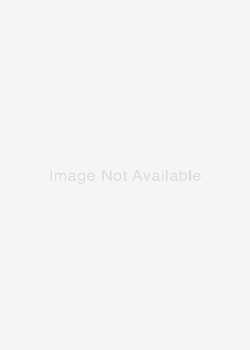

In [4]:
image.load_img(img_path+example_img, target_size=(350,250))

In order to find which images are duplicates, the strategy I will follow will be to read every image in the folder and extract its numeric representation, I will then aggregate the resulting array and compare them to find the duplicates.

In [93]:
def read_imgs(img_path):
    list_pics = os.listdir(img_path)
    list_pics = [img_path + img for img in list_pics]
    print(len(list_pics), " pictures")
    
    img_arrays = []
    with tqdm(total=len(list_pics), file=sys.stdout) as pbar:
        for n, img in enumerate(list_pics):
            try:
                img_arrays.append(cv2.imread(img,0).flatten().sum())
            except:
                img_arrays.append(0)
            pbar.set_description("done: %d" % (1 + n))
            pbar.update(1)
    return np.array(img_arrays)

In [94]:
%%time
imgs_sum = read_imgs(img_path)

259430  pictures



Wall time: 1h 24min 56s


In [95]:
#pd.DataFrame(imgs_sum, columns=["sum_array"]).to_csv("imgs_array_sum.csv", index=False)
len(imgs_sum)

259430

### Exceptions?
Had to capture exceptions in the function above since some images would break it, I will now explore what these exceptions are.

In [124]:
print(len(imgs_sum[imgs_sum == 0])) #corrupted images???
exceptions_index = np.where(imgs_sum == 0)[0]

248


These 248 images had already been explored in a previous notebook and validated as broken urls, will keep their indexes and will later append them to the broken urls file.

### Images not available
Visually picked the above image *191783.jpg* as an example of these images. I will now get the aggregated value of its array representation and compare it to the other images

In [128]:
img = cv2.imread(img_path+example_img,0)
not_available_sum = img.flatten().sum()
not_available_sum

349284817

In [133]:
print(len(imgs_sum[imgs_sum == not_available_sum]))
not_available_index = np.where(imgs_sum == not_available_sum)[0]

1025


In [134]:
list_pics = os.listdir(img_path)
img_path+list_pics[not_available_index[0]]

'./photos/165786.jpg'

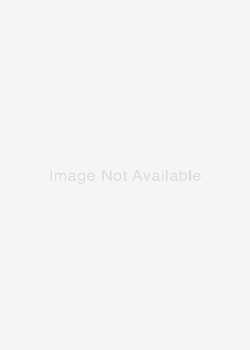

In [145]:
image.load_img(img_path+list_pics[not_available_index[328]], target_size=(350,250))

We have successfully identified the 1025 images "Not Available".  

I will now add the corrupted images and the not available images to the broken_url.csv file

In [189]:
#adding corrupted and not availables images to a dataframe with the right format
all_index = np.append(exceptions_index, not_available_index)
missing_df = pd.DataFrame([list_pics[i] for i in all_index], columns=["filename"])
missing_df["filename"] = missing_df["filename"].str.replace(".jpg", "")

In [178]:
#now importing the file with the urls so can join them up
photos_file = pd.read_table("./photos.txt", header=None)
photos_file = photos_file[0].str.split(pat=",", n=1, expand=True)
photos_file.columns = ["photo", "url"]
photos_file["photo"] = photos_file["photo"].str.lstrip("0")

all_missing_df = pd.merge(missing_df, photos_file, how="inner", left_on=["filename"], right_on=["photo"]).drop(columns=["filename"])

In [181]:
all_missing_df.head()

,photo,url
0,165136,http://piperlime.gap.com/webcontent/0008/707/6...
1,165137,http://piperlime.gap.com/webcontent/0008/982/9...
2,165138,http://piperlime.gap.com/webcontent/0008/982/9...
3,165139,http://piperlime.gap.com/webcontent/0008/312/9...
4,165140,http://piperlime.gap.com/webcontent/0009/196/5...


In [186]:
broken_urls = pd.read_csv("broken_urls.csv")
print(broken_urls.shape)
broken_urls.tail()

(33954, 2)


,photo,url
33949,99976,http://productshots0.modcloth.net/productshots...
33950,99977,http://productshots2.modcloth.net/productshots...
33951,99979,http://productshots1.modcloth.net/productshots...
33952,99981,http://productshots0.modcloth.net/productshots...
33953,99983,http://productshots3.modcloth.net/productshots...


In [187]:
broken_urls = broken_urls.append(all_missing_df)

In [188]:
broken_urls.to_csv("broken_urls.csv", index=False)

This ends the data cleansing needed to download the dataset, the broken_urls csv file will be send to the street2shop team for further help.